# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [1]:
import torch
import numpy as np
import pandas as pd
from collections import deque
from unityagents import UnityEnvironment
import random
import matplotlib.pyplot as plt
%matplotlib inline

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.13699999693781137


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

#### Config Gpu or Cpu

In [5]:
#DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

### 4.1 DDPG

#### Config DDPG Actor and Critic

In [6]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    #Actor (Policy) Model.

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    #Critic (Value) Model.

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)



#### Define DDPG Agent

In [7]:
import numpy as np
import random
import copy
import torch.optim as optim
from collections import namedtuple, deque

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128       # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay


class ddpgAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, n_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        print(DEVICE)
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(DEVICE)
        self.actor_target = Actor(state_size, action_size, random_seed).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(DEVICE)
        self.critic_target = Critic(state_size, action_size, random_seed).to(DEVICE)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((n_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        
        #for i in range(len(states)):
        #    self.memory.add(states[i, :], actions[i, :], rewards[i], next_states[i, :], dones[i])
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(DEVICE)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(DEVICE)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(DEVICE)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
ddpgagent = ddpgAgent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=42)

cpu


#### Define Training DDPG function

In [9]:
def TrainingDDPG(target_average_score, n_episodes=10000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        start_time = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = ddpgagent.act(states)
            
            env_info = env.step(actions)[brain_name]   
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            ddpgagent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        run_time = time.time() - start_time
        print('\r DDPG Episode {} \tAverage Score: {:.2f}, runtime：{:.3f}s'.format(i_episode, np.mean(scores_deque), run_time), end="")
        torch.save(ddpgagent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
        torch.save(ddpgagent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= target_average_score:
            print('\nDDPG solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(ddpgagent.actor_local.state_dict(), 'weights/checkpoint_actor.pth')
            torch.save(ddpgagent.critic_local.state_dict(), 'weights/checkpoint_critic.pth')
            break
            
    return scores

### 4.2 PPO

#### Config PPO Actor and Critic

In [10]:
ROLLOUT_LENGTH = 250 
GAE_LAMBDA = 0.95
OPTIMIZATION_EPOCHS = 10
PPO_RATIO_CLIP = 0.1
GRADIENT_CLIP = 0.75
HIDDEN_LAYERS = 32

In [11]:
class SubNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_units, output_size, seed):
        super(SubNetwork, self).__init__()
        dims = (input_size,) + hidden_units        
        self.layers = nn.ModuleList([layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.feature_dim = dims[-1]
        self.output_layer = layer_init(nn.Linear(self.feature_dim, output_size), 1e-3)
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)    
        return x    
            
class ActorAndCritic(nn.Module):
    
    def __init__(self, num_agents, state_size, action_size, seed):
        super(ActorAndCritic, self).__init__()
        self.seed = random.seed(seed)
        self.actor = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), action_size, seed)
        self.critic = SubNetwork(state_size, (HIDDEN_LAYERS, HIDDEN_LAYERS), 1, seed)
        self.std = nn.Parameter(torch.zeros(action_size))
        self.to(DEVICE)
        
    def forward(self, obs, action=None):
        obs = tensor(obs)
        a = self.actor(obs)
        v = self.critic(obs)
        mean = torch.tanh(a)
        dist = torch.distributions.Normal(mean, F.softplus(self.std))
        return (v, dist)

#### Define  PPO Agent

In [12]:
# Thank you for these helper routines to Shangtong Zhang 
# https://github.com/ShangtongZhang/DeepRL

def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

def to_np(t):
    return t.cpu().detach().numpy()

def tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    x = torch.tensor(x, device=DEVICE, dtype=torch.float32)
    return x

def random_sample(indices, batch_size):
    indices = np.asarray(np.random.permutation(indices))
    batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)
    for batch in batches:
        yield batch
    r = len(indices) % batch_size
    if r:
        yield indices[-r:]

class MeanStdNormalizer():
    def __init__(self):
        self.rms = None
        self.clip = 10.0
        self.epsilon = 1e-8

    def __call__(self, x):
        x = np.asarray(x)
        if self.rms is None:
            self.rms = RunningMeanStd(shape=(1, ) + x.shape[1:])
        self.rms.update(x)
        return np.clip((x - self.rms.mean) / np.sqrt(self.rms.var + self.epsilon),
                       -self.clip, self.clip)  

In [13]:
# Thank you for these helper routines to OpenAI.

# https://github.com/openai/baselines/blob/master/baselines/common/running_mean_std.py    
class RunningMeanStd(object):
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count)    
        
def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count

In [14]:
class Rollout():
    
    def __init__(self):
        # Stored values
        self.actions = []
        self.log_prob_actions = []
        self.values = []
        self.rewards = []
        self.episode_not_dones = []
        self.states = []
        # Calculated values
        self.returns = [0.0] * ROLLOUT_LENGTH
        self.advantages = [0.0] * ROLLOUT_LENGTH
        
    def save_prediction(self, actions, log_prob_actions, values):
        self.actions.append(actions)
        self.log_prob_actions.append(log_prob_actions)
        self.values.append(values)

    def save_consequences(self, rewards, episode_not_dones, states):
        self.rewards.append(rewards)
        self.episode_not_dones.append(episode_not_dones)
        self.states.append(states)
        
    def calculate_returns_and_advantages(self, final_reward):
        self.rewards.append(None)
        self.episode_not_dones.append(None)
        self.calculate_future_returns(final_reward)
        self.estimate_advantages()

    def calculate_future_returns(self, returns):
        for i in reversed(range(ROLLOUT_LENGTH)):
            returns = self.rewards[i] + GAMMA * self.episode_not_dones[i] * returns
            self.returns[i] = returns.detach() 

    def estimate_advantages(self):
        advantages = tensor(np.zeros((num_agents, 1)))
        # Go backwards through rollout steps and calculate advantages for each state action pair
        # Use GAE for PPO. 
        for i in reversed(range(ROLLOUT_LENGTH)):
            td = self.rewards[i] + (GAMMA * self.episode_not_dones[i] * self.values[i + 1]) - self.values[i]
            advantages = advantages * GAE_LAMBDA * GAMMA * self.episode_not_dones[i] + td
            self.advantages[i] = advantages.detach()               

    def stack_tensor(self, some_list):
        return torch.cat(some_list[:ROLLOUT_LENGTH], dim=0)
            
    def get_sample_data(self):
        states = self.stack_tensor(self.states)
        actions = self.stack_tensor(self.actions) 
        log_prob_actions = self.stack_tensor(self.log_prob_actions)
        returns = self.stack_tensor(self.returns)
        # Normalize advantages
        advantages = self.stack_tensor(self.advantages)
        advantages = (advantages - advantages.mean()) / advantages.std()        
        return (states, actions, log_prob_actions, returns, advantages)
    
class ppoAgent():   
    
    def __init__(self, num_agents, state_size, action_size, seed):
        self.network = ActorAndCritic(num_agents, state_size, action_size, seed)
        self.first_states = True
        self.total_steps = 0
        self.state_normalizer = MeanStdNormalizer()
        
    def evaluate_actions_against_states(self, states, actions):
        value, action_distribution = self.network(states, actions)
        log_prob = self.get_log_prob(action_distribution, actions)
        return (log_prob, value)
    
    def get_log_prob(self, action_distribution, actions):
        return action_distribution.log_prob(actions).sum(-1).unsqueeze(-1)
    
    def get_prediction(self, states):
        if self.first_states:
            self.states = states
            self.first_states = False
        #self.latest_actions, self.latest_log_prob, self.latest_values = self.get_prediction_from_states(self.states)
        self.latest_values, action_distribution = self.network(self.states)
        self.latest_actions = action_distribution.sample()
        self.latest_log_prob = self.get_log_prob(action_distribution, self.latest_actions)
        return self.latest_actions
    
    def step(self, states, actions, rewards, next_states, dones):
        rewards = np.asarray(rewards)
        next_states = self.state_normalizer(next_states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
        dones = np.asarray(dones).astype(int)
        rewards = tensor(rewards).unsqueeze(-1)
        episode_not_dones = tensor(1 - dones).unsqueeze(-1)
        states = tensor(self.states)        
        self.rollout.save_consequences(rewards, episode_not_dones, states)

        self.states = next_states
                
    def start_rollout(self):
        self.rollout = Rollout()
            
    def process_rollout(self, states):
        self.save_final_results(states)
        self.rollout.calculate_returns_and_advantages(self.latest_values.detach())
        self.optimize()
        self.first_states = True
        
    def save_final_results(self, states):    
        self.get_prediction(states)
        self.rollout.save_prediction(self.latest_actions, self.latest_log_prob, self.latest_values)
   
    def save_weights(self):
        #print("======== Saving weights ==========")
        torch.save(self.network.state_dict(), "weights/trained_weights.pth")

    def optimize(self):
        # Now use tensors for 's', 'a', 'log_pi_a', 'ret', 'adv' for training
        # states, actions, log prob actions, returns, advantages (1 row / timestep, 1 column per worker)

        states, actions, log_probs_old, returns, advantages = self.rollout.get_sample_data()
        actions = actions.detach()
        log_probs_old = log_probs_old.detach()
        optimizer = torch.optim.Adam(self.network.parameters(), 3e-4, eps=1e-5)
        for i in range(OPTIMIZATION_EPOCHS):
            number_timesteps = states.size(0)
            timesteps_to_sample = random_sample(np.arange(number_timesteps), BATCH_SIZE) 
            for timestep in timesteps_to_sample:
                t = tensor(timestep).long()
                # Get data for all workers from sampled timestep 
                sampled_states = states[t]
                sampled_actions = actions[t]
                sampled_log_probs_old = log_probs_old[t]
                sampled_returns = returns[t]
                sampled_advantages = advantages[t]
                self.optimize_with_sampled_worker_data(optimizer, sampled_states,
                                                                  sampled_actions,
                                                                  sampled_log_probs_old,
                                                                  sampled_returns,
                                                                  sampled_advantages)
        steps = ROLLOUT_LENGTH * num_agents
        # Total steps used to train network
        self.total_steps += steps
        
    def optimize_with_sampled_worker_data(self, optimizer, sampled_states, sampled_actions, sampled_log_probs_old, sampled_returns, sampled_advantages):
        # Get log_prob(actions) and value given states
        # Pass in states for all workers x batch_size.
        log_prob_action, value = self.evaluate_actions_against_states(sampled_states, sampled_actions)
        
        policy_loss = self.get_policy_loss(log_prob_action, sampled_log_probs_old, sampled_advantages)
        value_loss = self.get_value_loss(value, sampled_returns)
        
        # Do the actual optimization
        optimizer.zero_grad()
        # Overall loss function for training both networks at once. Get gradients on weights.
        (policy_loss + value_loss).backward()
        # Clip weight gradients 
        nn.utils.clip_grad_norm_(self.network.parameters(), GRADIENT_CLIP) 
        # Run actual optimization
        optimizer.step()
        
    def get_policy_loss(self, log_prob_action, sampled_log_probs_old, sampled_advantages):
        # This is the core of PPO
        # ratio = new prob / old prob for all workers
        ratio = (log_prob_action - sampled_log_probs_old).exp() 
        # Clip loss on the upside
        clamped_ratio = ratio.clamp(1.0 - PPO_RATIO_CLIP, 1.0 + PPO_RATIO_CLIP)
        obj = ratio * sampled_advantages
        obj_clipped = clamped_ratio * sampled_advantages
        policy_loss = -torch.min(obj, obj_clipped).mean() 
        return policy_loss
    
    def get_value_loss(self, value, sampled_returns):
        # Mean squared error
        value_loss = 0.5 * (sampled_returns - value).pow(2).mean()
        return value_loss

#### Define training PPO function

In [15]:
class TrainingPPOSession():
    
    def __init__(self, num_workers, ppoagent):
        self.num_workers = num_workers
        self.online_rewards = np.zeros(num_workers)
        self.mean_last_100 = 0
        self.mean_scores = []
        self.ppoagent = ppoagent
        self.timespent = 0

    def train_ppo(self, agent, target_average_score, max_episodes=300):
        #print("Attempting to reach 100 episode trailing average of {:.2f} in under {} episodes.".format(target_average_score, max_episodes))
        #agent.save_weights()
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment   
        self.num_episodes = 0
        self.last_100_scores = deque(maxlen=100)
        self.episode_scores = [list() for i in range(num_agents)]
        self.episodes_finished = 0
        self.target_average_score = target_average_score
        self.timespent = time.time()
        while True:
            mean_last_100 = self.run_rollout(agent, env_info)
            agent.process_rollout(states)
            #print("\rEpisode {}\tLast 100: {:.2f},run time：{:.3f}s".format(self.num_episodes, mean_last_100, run_time))
            if mean_last_100 > target_average_score:
                print('\nPPO solved in {:d} episodes!\tAverage Score: {:.2f}'.format(self.num_episodes, np.mean(self.last_100_scores)))
                #print("Reached target! mean_last_100 %s" % mean_last_100)
                agent.save_weights() 
                break
            if self.num_episodes > max_episodes:
                print("Failed to reach target in {} episodes.".format(self.num_episodes))
                break
        return self.mean_scores 
    
    def get_actions_from_policy(self, states):
        actions = self.ppoagent.get_prediction(states)          # Run the policy 
        actions = to_np(actions)                        # Extract actions
        actions = np.clip(actions, -1, 1)               # all actions between -1 and 1
        return actions
    
    def step_environment(self, env, actions):
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment        
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished for each agent
        return (next_states, rewards, dones)
                                
    def run_episode(self, env_info):
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        while True:
            actions = self.get_actions_from_policy(states)
            next_states, rewards, dones = self.step_environment(env, actions)
            
    def run_rollout(self, agent, env_info):
        #print("Run rollout")
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.start_rollout()
        for t in range(ROLLOUT_LENGTH):
            actions = self.get_actions_from_policy(states)            
            next_states, rewards, dones = self.step_environment(env, actions)
        
            # Save rewards
            self.online_rewards += rewards                          # Accumulate ongoing (un-normalized) rewards for each agent
            for i, done in enumerate(dones):
                if done:                                       # For a worker whose episode is done...
                    #print("Worker %s finished at timestep %s" % (i, t))
                    self.end_episode(i, self.online_rewards[i])
                    self.online_rewards[i] = 0                 # Reset accumulated reward for next episode
                    if len(self.last_100_scores) != 0:
                        self.mean_last_100 = np.mean(self.last_100_scores)
                    if self.mean_last_100 > self.target_average_score:
                        #print("Breaking")
                        break
            #print("%s step" % t)            
            agent.step(states, actions, rewards, next_states, dones) # Teach the agent 
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step

        #print("Steps in rollout: {}".format(t+1))        
        return self.mean_last_100    

    def end_episode(self, agent_index, score):
        self.episode_scores[agent_index].append(score)   # Save the reward they accumulated in the episode
        self.episodes_finished +=1
       
        if (self.episodes_finished % num_agents) == 0:
            self.num_episodes += 1
            total_over_agents = 0
            for i in range(num_agents):
                total_over_agents += self.episode_scores[i][-1]
            mean_score_over_agents = total_over_agents / num_agents    
            self.last_100_scores.append(mean_score_over_agents)
            self.mean_scores.append(mean_score_over_agents)
            run_time = time.time() - self.timespent
            print("\r PPO Episode {}  \tAverage Score: {:.2f}, runtime：{:.3f}s".format(self.num_episodes, np.mean(self.last_100_scores), run_time), end="")
            self.timespent = time.time()

In [16]:
def TrainingPPO(target_average_score):
    agent = ppoAgent(num_agents, state_size=state_size, action_size=action_size, seed=0)
    ppoSession = TrainingPPOSession(num_agents, agent)
    score = ppoSession.train_ppo(agent, target_average_score)
    return score

### 4.3 Compare the two algorithms

In [17]:
ddpgScores = TrainingDDPG(30)
print("========================")
ppoScores = TrainingPPO(30)


Episode 100	Average Score: 9.36e: 9.36, runtime：8.230s
 DDPG Episode 172 	Average Score: 30.04, runtime：8.262s
DDPG solved in 172 episodes!	Average Score: 30.04
 PPO Episode 189  	Average Score: 30.01, runtime：5.626s
PPO solved in 189 episodes!	Average Score: 30.01


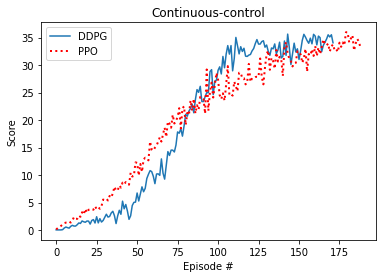

In [18]:
def plot_scores(ddpgScores, ppoScores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(ddpgScores)), ddpgScores, label='DDPG')
    plt.plot(np.arange(len(ppoScores)), ppoScores, c='r', label='PPO', linewidth=2, linestyle=':')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(f'Continuous-control')
    plt.legend(loc='upper left');

plot_scores(ddpgScores,ppoScores)

In [19]:
env.close()